In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from netgen.meshing import Mesh as NGMesh
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.backends.backend_pdf import PdfPages
import os

# Für Exceptions
from netgen.meshing import NgException

# --------------------------------------------------------
# Parameter und Konstanten für das Proton
# --------------------------------------------------------
q_p = 1.602176634e-19      # Protonenladung [C] (+)
m_p = 1.67262192369e-27    # Protonenmasse [kg]

# Zeit-Simulations-Parameter
Tend = 1e-5      # Endzeit
dt   = 1e-10     # Zeitschritt

# Liste von Anfangsradien, für die wir simulieren
r0_values = [0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045]
r0_values = [0.001, 0.0015, 0.0045, 0.0055, 0.0065, 0.0075, 0.0085, 0.0095]
r0_values = [0.004, 0.0045, 0.0055]
r0_values = [0.003, 0.0035, 0.0040]
# Fixe Anfangsgeschwindigkeit
v_0 = 1.0e5

# --------------------------------------------------------
# Einlesen des Mesh + Vektorpotential A
# --------------------------------------------------------
order = 4
i_c   = 100
ampere_dir = "results/homo/" + str(i_c)

filename_gfA  = ampere_dir + f"/results/gfA_homo_{i_c}_{order}ord.vec"
filename_mesh = ampere_dir + f"/results/mesh_homo_{i_c}_{order}ord.vol"

ngmesh = NGMesh()
ngmesh.Load(filename_mesh)
mesh = Mesh(ngmesh)

V = HCurl(mesh, order=order-1, nograds=True, dirichlet="outer")
gfA = GridFunction(V)
gfA.Load(filename_gfA)

# Magnetische Flussdichte B = curl(A)
Bfield = curl(gfA)

# --------------------------------------------------------
# Hilfsfunktionen
# --------------------------------------------------------
def magnetic_field(pos):
    """
    Liest das B-Feld aus. Falls 'pos' außerhalb des Mesh liegt, 
    wird None zurückgegeben.
    """
    px, py, pz = pos
    try:
        pt = mesh(px, py, pz)
        val = Bfield(pt)
        return np.array(val)
    except NgException:
        # Punkt liegt außerhalb des Mesh
        return None

def rhs_proton(t, state):
    """
    Rechte Seite m_p * a = q_p (v x B).
    Falls B = None => out of mesh => Simulation-Abbruch.
    """
    x, y, z, vx, vy, vz = state
    B_vec = magnetic_field((x, y, z))
    
    if B_vec is None:
        # Abbruch, weil Teilchen aus dem Mesh geflogen ist
        raise ValueError("Proton is out of mesh - simulation should stop.")
    
    v_vec = np.array([vx, vy, vz])
    F = q_p * np.cross(v_vec, B_vec)  # Lorentzkraft
    ax, ay, az = F / m_p             # a = F/m
    return np.array([vx, vy, vz, ax, ay, az])

def rk4_step(state, dt, t):
    """
    Einfacher Runge-Kutta 4. Ordnung Integrator:
      state_{n+1} = state_n + 1/6*(k1 + 2*k2 + 2*k3 + k4).
    """
    k1 = rhs_proton(t, state)
    k2 = rhs_proton(t + dt/2, state + dt*k1/2)
    k3 = rhs_proton(t + dt/2, state + dt*k2/2)
    k4 = rhs_proton(t + dt,   state + dt*k3)
    return state + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

def simulate_proton_trajectory(r_0, v_0, dt, Tend):
    """
    Simuliert das Proton für gegebenen Anfangsradius r_0 und
    Geschw. v_0. Bricht ab, wenn 'out-of-mesh'.
    """
    # Startposition s0 = (r_0, 0, 0), 
    # Geschw. v0 = (0, v_0, 0)
    state = np.array([r_0, 0.0, 0.0, 0.0, v_0, 0.0], dtype=float)
    trajectory = []
    t = 0.0

    while t < Tend:
        trajectory.append(state.copy())
        try:
            state = rk4_step(state, dt, t)
        except ValueError as e:
            print(f"[r0={r_0:.4f}] Simulation abgebrochen:", e)
            break
        t += dt

    return np.array(trajectory)

# --------------------------------------------------------
# Simulation für alle r_0 durchführen
# --------------------------------------------------------
all_trajectories = {}
for r_0 in r0_values:
    traj = simulate_proton_trajectory(r_0, v_0, dt, Tend)
    all_trajectories[r_0] = traj
    print(f"r_0 = {r_0:.4f}: Trajectory length = {len(traj)}")

[r0=0.0030] Simulation abgebrochen: Proton is out of mesh - simulation should stop.
r_0 = 0.0030: Trajectory length = 19804
[r0=0.0035] Simulation abgebrochen: Proton is out of mesh - simulation should stop.
r_0 = 0.0035: Trajectory length = 19574
[r0=0.0040] Simulation abgebrochen: Proton is out of mesh - simulation should stop.
r_0 = 0.0040: Trajectory length = 19334


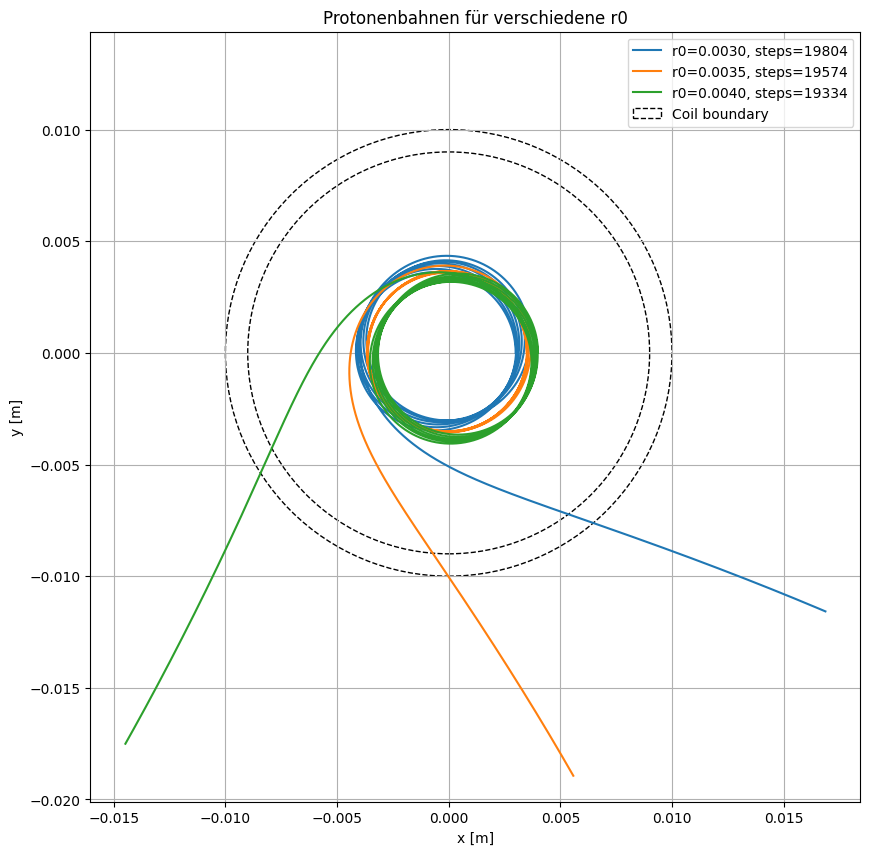

In [2]:
# --------------------------------------------------------
# 2D-Plot (x-y) aller Trajektorien
# --------------------------------------------------------
plt.figure(figsize=(10,10))

for r_0 in r0_values:
    traj = all_trajectories[r_0]
    xpos = traj[:, 0]
    ypos = traj[:, 1]
    plt.plot(xpos, ypos, label=f"r0={r_0:.4f}, steps={len(traj)}")

# Add red circles at (0,0) with radii 0.009 and 0.01
circle1 = plt.Circle((0, 0), 0.009, color='k', fill=False, linestyle='--',label=f"Coil boundary")
circle2 = plt.Circle((0, 0), 0.01, color='k', fill=False, linestyle='--')

plt.gca().add_artist(circle1)
plt.gca().add_artist(circle2)

# Calculate plot limits
x_min = min(traj[:, 0].min() for traj in all_trajectories.values())
x_max = max(traj[:, 0].max() for traj in all_trajectories.values())
y_min = min(traj[:, 1].min() for traj in all_trajectories.values())
y_max = max(traj[:, 1].max() for traj in all_trajectories.values())

x_max = max(abs(x_max), abs(x_min))
y_max = max(abs(y_max), abs(y_min))
max_val = max(x_max, y_max)

# Set plot limits to center (0,0) and ensure all trajectories are visible
plt.xlim(-max_val, max_val)
plt.ylim(-max_val, max_val)
plt.axis('square')

plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Protonenbahnen für verschiedene r0")
plt.legend()
plt.grid(True)
plt.show()

In [3]:
# --------------------------------------------------------
# 3D-Plot (Plotly) aller Trajektorien
# --------------------------------------------------------
fig = go.Figure()

for r_0 in r0_values:
    traj = all_trajectories[r_0]
    xpos = traj[:, 0]
    ypos = traj[:, 1]
    zpos = traj[:, 2]
    
    fig.add_trace(
        go.Scatter3d(
            x=xpos, 
            y=ypos, 
            z=zpos,
            mode='lines',
            name=f"r0={r_0:.4f}",
            line=dict(width=4)
        )
    )

fig.update_layout(
    title="3D-Protonenbahnen (verschiedene r0)",
    scene=dict(
        xaxis_title='x [m]',
        yaxis_title='y [m]',
        zaxis_title='z [m]',
        aspectmode='data'
    ),
    width=800,
    height=700
)
fig.show()

In [17]:
# --------------------------------------------------------
# Plot in NGSolve-GUI mit "lines" (ähnlich 'electron-lines')
# --------------------------------------------------------
all_lines_proton = []
colors = ['green', 'blue', 'red', 'purple', 'orange', 'cyan']  # Define a list of colors

r_str = "_".join([str(r) for r in r0_values])    
i_c_str = str(i_c)
filename_3dplt = "results/prot/plot/trajectory_proton_" + i_c_str + "_" + r_str + ".html"

for idx, (r_0, traj) in enumerate(all_trajectories.items()):
    color = colors[idx % len(colors)]  # Cycle through the colors list
    lines_proton = {
        "type": "lines",
        "position": np.array([
            [traj[k, 0:3], traj[k+1, 0:3]] 
            for k in range(traj.shape[0] - 1)
        ]).flatten().tolist(),  # Convert numpy array to list
        "name": f"proton_r0_{r_0}",
        "color": color
    }
    all_lines_proton.append(lines_proton)

    # Add dot at start position with the same color
    start_dot = {
        "type": "points",
        "position": traj[0, 0:3].tolist(),  # Convert numpy array to list
        "name": f"start_r0_{r_0}",
        "color": color,
        "size": 5
    }
    all_lines_proton.append(start_dot)

# Wir zeichnen B und das Coil-Material
scene = Draw(
    Bfield, 
    mesh.Materials("coil"), 
    draw_surf=False, 
    vectors={"grid_size": 100},
    objects=all_lines_proton,
    settings={
      "Objects": {
         "Edges": False, 
         "Surface": True,
         "Wireframe": False
      }
    },
    filename = filename_3dplt
)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Edges': False, …

# Exports 

In [5]:
order = 4
i_c   = 100
order_str = str(order)
i_c_str = str(i_c)

project_directory = os.getcwd()
target_folder_name = "results/prot/"

target_folder_path = os.path.join(project_directory, target_folder_name)

# Check if the folder exists
if not os.path.exists(target_folder_path):
    # Create the folder if it doesn't exist
    os.makedirs(target_folder_path)
    os.makedirs(target_folder_path + "/results")
    os.makedirs(target_folder_path + "/plot")
    print(f"Folder '{target_folder_name}' created.")
else:
    # Skip creation if it exists
    print(f"Folder '{target_folder_name}' already exists, skipping creation.")
    

Folder 'results/prot/' already exists, skipping creation.


In [18]:
dir = "results/prot/"

filename_traj2d = dir + "/plot/prot_traj_2d_" + i_c_str + "_ord" + order_str + ".pdf"
    
override = 1

if override == 1:
    with PdfPages(filename_traj2d) as pdf:
        plt.figure(figsize=(8.27, 11.69))

        for r_0 in r0_values:
            traj = all_trajectories[r_0]
            xpos = traj[:, 0]
            ypos = traj[:, 1]
            plt.plot(xpos, ypos, label=f"r0={r_0:.4f}, steps={len(traj)}")

        # Add red circles at (0,0) with radii 0.009 and 0.01
        circle1 = plt.Circle((0, 0), 0.009, color='k', fill=False, linestyle='--',label=f"Coil boundary")
        circle2 = plt.Circle((0, 0), 0.01, color='k', fill=False, linestyle='--')

        plt.gca().add_artist(circle1)
        plt.gca().add_artist(circle2)

        # Calculate plot limits
        x_min = min(traj[:, 0].min() for traj in all_trajectories.values())
        x_max = max(traj[:, 0].max() for traj in all_trajectories.values())
        y_min = min(traj[:, 1].min() for traj in all_trajectories.values())
        y_max = max(traj[:, 1].max() for traj in all_trajectories.values())

        x_max = max(abs(x_max), abs(x_min))
        y_max = max(abs(y_max), abs(y_min))
        max_val = max(x_max, y_max)

        # Set plot limits to center (0,0) and ensure all trajectories are visible
        plt.xlim(-max_val, max_val)
        plt.ylim(-max_val, max_val)
        plt.axis('square')

        plt.xlabel("x [m]")
        plt.ylabel("y [m]")
        plt.title("Protonenbahnen für verschiedene r0")
        plt.legend()
        plt.grid(True)
        
        pdf.savefig()
        plt.close()
        
    print(" ########################### ")
    print(" ------ Traj2D saved ------ ")
    print(" ########################### ")
else:
    print(" ########################### ")
    print(" ---- Traj2D not saved ---- ")
    print(" ########################### ")

 ########################### 
 ------ Traj2D saved ------ 
 ########################### 
